In [3]:
import glob
import clip
import os
from torch import nn
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
# from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import requests

from clip_prefix_captioning import MLP, ClipCaptionModel, ClipCaptionPrefix, generate_beam, generate2
from nltk.sentiment import SentimentIntensityAnalyzer

In [4]:
D = torch.device
CPU = torch.device('cpu')

is_gpu = True

def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

In [5]:
current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_weights.pt')

In [6]:
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [7]:
prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

In [8]:
def generate_caption(img_file, display_img=False, use_beam_search=False, return_all_beam=False, return_clip_emb=False):
    image = io.imread(img_file)
    pil_image = PIL.Image.fromarray(image)
    if display_img:
        display(pil_image.resize((512, 512)))
    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        if return_all_beam:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)
        else:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

    if return_clip_emb:
        return generated_text_prefix, prefix
    else:
        return generated_text_prefix

In [9]:
def clip_encode_caption(caption):
    with torch.no_grad():
        caption_tokenized = clip.tokenize(caption, truncate=True).to(device)
        clip_caption_rep = clip_model.encode_text(caption_tokenized).to(device, dtype=torch.float32)
    return clip_caption_rep

In [10]:
def choose_best_caption(captions, img_clip_emb):
    sia = SentimentIntensityAnalyzer()

    captions_clip_embs = [clip_encode_caption(caption).squeeze(dim=0).cpu().numpy() for caption in captions]
    emb_mtx = np.stack(np.array([img_clip_emb] + captions_clip_embs))

    semantic_sim_scores = cosine_similarity(emb_mtx)[0,1:]
    polairty_scores = np.array([sia.polarity_scores(caption)['neu'] for caption in captions])
    length_scores = np.array([len(caption.split(' ')) for caption in captions])
    winner = np.argmax(semantic_sim_scores + polairty_scores + length_scores)

    return captions[winner], captions_clip_embs[winner], polairty_scores[winner]

In [11]:
def find_most_sim_emb(input_emb_idx, sim_mtx):
    sim_mtx[input_emb_idx,input_emb_idx] = -1
    idx_most_sim = sim_mtx[input_emb_idx].argmax()
    return idx_most_sim

# Download Unsplash Dataset

In [12]:
data_files_path = os.path.join(os.path.dirname(current_directory), "data", "unsplash-research-dataset-lite-latest")
documents = ['photos', 'keywords', 'collections', 'conversions', 'colors']
datasets = {}

for doc in documents:
    files = glob.glob(data_files_path + '/' + doc + ".tsv*")
    print(files)
    subsets = []
    for filename in files:
        df = pd.read_csv(filename, sep='\t', header=0)
        subsets.append(df)

    datasets[doc] = pd.concat(subsets, axis=0, ignore_index=True)

['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/photos.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/keywords.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/collections.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/conversions.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/colors.tsv000']


In [13]:
to_download = datasets['photos'].head(10000).index

In [14]:
imgs_path = os.path.join(os.path.dirname(current_directory), "data", "unsplash-research-dataset-lite-latest", "images")
if not os.path.exists(imgs_path):
    os.makedirs(imgs_path)

In [ ]:
for index in tqdm(to_download):
    try:
        response = requests.get(datasets['photos'].loc[index,'photo_image_url'])
        file = open(f'{imgs_path}/{index}.png', "wb")
        file.write(response.content)
        file.close()
    except:
        print(f'index {index} failed!')

# Calculate CLIP and Style embeddings

In [15]:
tested = datasets['photos'].loc[to_download]

In [ ]:
style_embs = {}
clip_embs = {}
caption_embs = {}

for img_file in os.listdir(imgs_path)[:10]:
    try:
        captions, img_clip_emb = generate_caption(f'{imgs_path}/{img_file}', use_beam_search=True, return_all_beam=True, return_clip_emb=True)
        img_clip_emb = img_clip_emb.squeeze(dim=0).cpu().numpy()
        caption, caption_clip_emb, caption_neu_score = choose_best_caption(captions, img_clip_emb)
        style = img_clip_emb - caption_clip_emb
        index = int(img_file.replace('.png',''))
        style_embs[index] = style
        clip_embs[index] = img_clip_emb
        caption_embs[index] = caption_clip_emb
        tested.loc[index, 'caption'] = caption
        tested.loc[index, 'neu_score'] = caption_neu_score
    except:
        continue

In [ ]:
tested = tested.reset_index()

In [ ]:
tested['style_emb'] = tested['index'].map(style_embs)
tested['clip_emb'] = tested['index'].map(clip_embs)
tested['caption_emb'] = tested['index'].map(caption_embs)

In [ ]:
tested = tested[tested['style_emb'].notnull()]

In [ ]:
tested = tested.reset_index(drop=True)

In [ ]:
style_sims = cosine_similarity(np.stack(np.array(tested['style_emb'].tolist())))
tested['most_sim_style'] =  tested.apply(lambda row: tested.loc[find_most_sim_emb(row.name, style_sims),
                                                                'photo_url'], axis=1)
clip_sims = cosine_similarity(np.stack(np.array(tested['clip_emb'].tolist())))
tested['most_sim_clip'] = tested.apply(lambda row: tested.loc[find_most_sim_emb(row.name, clip_sims),
                                                                'photo_url'], axis=1)

# Clustering

In [ ]:
num_clusters = 3
kmeans_style = KMeans(n_clusters=num_clusters, random_state=0).fit(np.stack(tested['style_emb'].values))
kmens_clip = KMeans(n_clusters=num_clusters, random_state=0).fit(np.stack(tested['clip_emb'].values))

In [ ]:
style_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.stack(tested['style_emb'].values))
clip_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.stack(tested['clip_emb'].values))

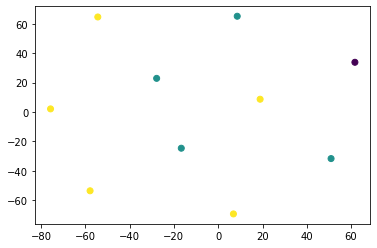

In [59]:
plt.scatter(style_embedded[:, 0], style_embedded[:, 1], c = kmeans_style.labels_)
plt.show()

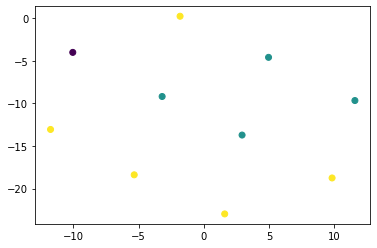

In [60]:
plt.scatter(clip_embedded[:, 0], clip_embedded[:, 1], c = kmeans_style.labels_)
plt.show()